# RealNVP

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1),
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb)

In [1]:
import time
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_datasets

import jax
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
from functools import partial

from tensorflow.data import Dataset
import tensorflow_probability as tfp

from flax import struct
from flax.training import train_state
import flax.linen as nn

import optax
from clu import metrics

2023-09-14 21:20:22.339507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 0. Training Parameters

In [2]:
NUM_SAMPLES = 30_000
COULPING_LAYERS = 6

INPUT_DIM = 2
HIDDEN_DIM = 256
REGULARIZATION = 2e-3
BATCH_SIZE = 256
EPOCHS = 120

# kwargs for model's tabulate function
console_kwargs = {"width": 100, 
                  "force_terminal": False, 
                  "force_jupyter": True,
                  "soft_wrap": True}

## 1. Preparing Moon dataset

The shape of moon dataset:  (30000, 2)


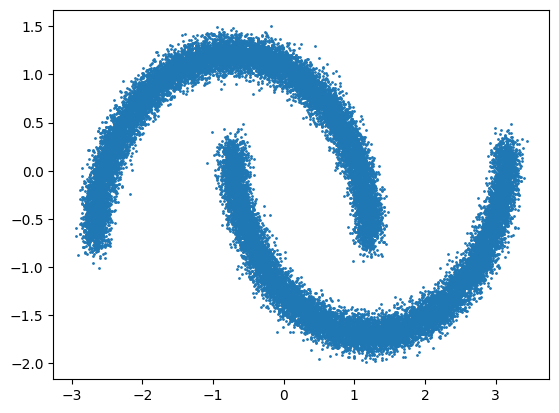

In [3]:
data = sk_datasets.make_moons(n_samples=NUM_SAMPLES, noise=5e-2)[0].astype("float32")
print("The shape of moon dataset: ", data.shape)
# data normalization
mean = data.mean()
std = data.std()
moon_data = (data - mean) / (std ** 2)
# visualize dataset
plt.scatter(moon_data[:, 0], moon_data[:, 1], s=1.0)
plt.show()

## 2. Building RealNVP

Building backbone layer

In [4]:
class Coupling(nn.Module):
    
    last_activation:bool = True
    n_layers:int = 5
    dims:tuple = tuple([HIDDEN_DIM] * (n_layers - 1) + [INPUT_DIM])
    
    def setup(self):
        layers = []
        for i in range(self.n_layers):
            layers.append(nn.Dense(features=self.dims[i]))
            if i != (self.n_layers - 1):
                layers.append(nn.relu)
        if self.last_activation:
            layers.append(nn.tanh)
        self.network = nn.Sequential(layers)

    def __call__(self, x):
        return self.network(x)

In [5]:
print(Coupling(False).tabulate(jax.random.PRNGKey(0), 
                  jnp.ones((10, 2)),
                  console_kwargs=console_kwargs))

                                        Coupling Summary                                        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path             ┃ module     ┃ inputs          ┃ outputs         ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  │ Coupling   │ float32[10,2]   │ float32[10,2]   │                          │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network          │ Sequential │ float32[10,2]   │ float32[10,2]   │                          │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_0 │ Dense      │ float32[10,2]   │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[2,256]   │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 768 (3.1 KB)             │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_2 │ Dense      │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[256,256] │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_4 │ Dense      │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[256,256] │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_6 │ Dense      │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │            │                 │                 │ kernel: float32[256,256] │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_8 │ Dense      │ float32[10,256] │ float32[10,2]   │ bias: float32[2]         │
│                  │            │                 │                 │ kernel: float32[256,2]   │
│                  │            │                 │                 │                          │
│                  │            │                 │                 │ 514 (2.1 KB)             │
├──────────────────┼────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│                  │            │                 │           Total │ 198,658 (794.6 KB)       │
└──────────────────┴────────────┴─────────────────┴─────────────────┴──────────────────────────┘
                                                                                                
                              Total Parameters: 198,658 (794.6 KB)                              

In [6]:
class RealNVP(nn.Module):
    num_couplings = COULPING_LAYERS

    def setup(self):
        self.mask = np.array([[0, 1], [1, 0]] * (self.num_couplings // 2), dtype=np.float32)
        self.t = [Coupling(last_activation=None) for i in range(self.num_couplings)]
        self.s = [Coupling() for i in range(self.num_couplings)]
    
    def __call__(self, x, training=True):
        log_det_inv = np.zeros_like(x.shape[0])
        (start, end, step) = (self.num_couplings -1 , -1, -1) if training else (0, self.num_couplings, 1)
        
        z = x
        for i in range(start, end, step):
            z_masked = z * self.mask[i]
            s = self.s[i](z_masked) * (1 - self.mask[i])
            t = self.t[i](z_masked) * (1 - self.mask[i])
            if training:
                z = z_masked + (1 - self.mask[i]) * (z - t) * jnp.exp(-s)
                log_det_inv -= jnp.sum(s, axis=-1)
            else:
                z = z_masked + (1 - self.mask[i]) * (z * jnp.exp(s) + t)
        return z, log_det_inv

In [7]:
print(RealNVP().tabulate(jax.random.PRNGKey(0),
                  jnp.ones((10, 2)), 
                  training=True,
                  depth=2,
                  console_kwargs=console_kwargs))

                                   RealNVP Summary                                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module     ┃ inputs           ┃ outputs         ┃ params             ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│             │ RealNVP    │ - float32[10,2]  │ - float32[10,2] │                    │
│             │            │ - training: True │ - float32[10]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_5         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_5/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_5         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_5/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_4         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_4/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_4         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_4/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_3         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_3/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_3         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_3/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_2         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_2/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_2         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_2/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_1         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ s_1/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_1         │ Coupling   │ float32[10,2]    │ float32[10,2]   │                    │
├─────────────┼────────────┼──────────────────┼─────────────────┼────────────────────┤
│ t_1/network │ Sequential │ float32[10,2]    │ float32[10,2]   │ 198,658 (794.6 KB) 

## 3. Functions for the `Train State`

In [8]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output("loss")

class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(model, param_key, learning_rate):
    params = model.init(param_key, jnp.ones((BATCH_SIZE, INPUT_DIM)))["params"]
    tx = optax.adam(learning_rate=learning_rate)

    return TrainState.create(
            apply_fn = model.apply,
            params = params,
            tx = tx,
            metrics = Metrics.empty())

## 4. Train step functions

In [9]:
# l2 loss function for weights regularization
def l2_loss(x, alpha):
    return alpha * (x ** 2)

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        z, log_det = state.apply_fn({"params": params},
                                     batch,
                                     training=True)
        
        log_prob = multivariate_normal.logpdf(z, jnp.zeros(2), 
                                              jnp.eye(2)) + log_det
        loss = -log_prob.mean()
        # regularization
        loss += sum(l2_loss(weights, alpha=REGULARIZATION).mean() for weights in jax.tree_util.tree_leaves(params))
        return loss

    # compute loss and apply gradients
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    # update metrics
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    
    return state

# Generate data from multivariate normal distribution
@partial(jax.jit, static_argnums = (1,))
def generate(state, num_samples):
    samples = jax.random.multivariate_normal(jax.random.PRNGKey(0), 
                                             mean=jnp.zeros(2), 
                                             cov=jnp.eye(2), 
                                             shape=(num_samples,))
    xs, _ = state.apply_fn({"params": state.params},
                                samples,
                                training = False)
    return samples, xs


# Show f(x) and g(x) transformations
def show_distribution(moon_data, state, num_samples):
    moon_data_slices = moon_data[:num_samples]
    zs, _ = state.apply_fn({"params": state.params},
                          moon_data_slices,
                          training=True)
    samples, xs = generate(state, num_samples)

    plt.figure(figsize=(13, 3))
    # 1. Plot the moon data
    ax = plt.subplot(1, 4, 1)
    ax.scatter(moon_data_slices[:, 0], moon_data_slices[:, 1], c="tomato", s=1)
    ax.set_title("data")
    
    # 2. Plot forward process result
    ax = plt.subplot(1, 4, 2)
    ax.scatter(zs[:, 0], zs[:, 1], c="tomato", s=1)
    ax.set_title("$z = f(x)$")
    
    # 3. Plot samples from distribution
    ax = plt.subplot(1, 4, 3)
    ax.scatter(samples[:, 0], samples[:, 1], c="steelblue", s=1)
    ax.set_title("samples")
    
    # 4. Plot backward proess result
    ax = plt.subplot(1, 4, 4)
    ax.scatter(xs[:, 0], xs[:, 1], c="steelblue", s=1)
    ax.set_title("$x = g(z)$")

    plt.show()

## 5. Defining TF dataset and model

In [10]:
# dataset
train_ds = Dataset.from_tensor_slices(moon_data)
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(1)

# model
realnvp = RealNVP()
state = create_train_state(RealNVP(), jax.random.PRNGKey(0), learning_rate=1e-4)

2023-09-14 21:20:24.029807: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 6. Training

Epoch 120	Time:0.01 min
	Train loss: 1.6727


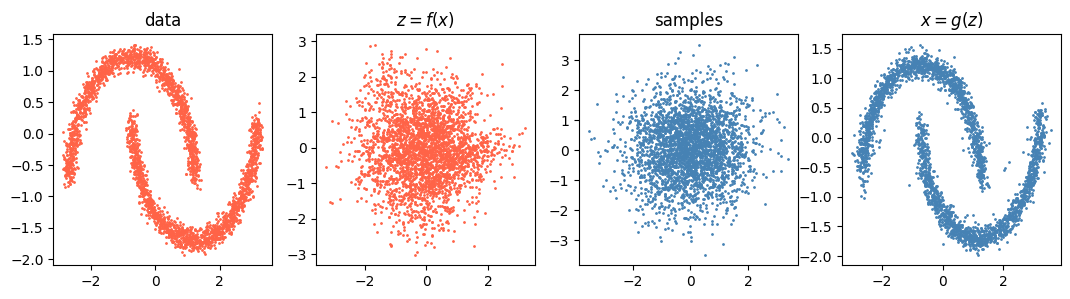

In [11]:
loss_hist = []
for i in range(EPOCHS):
    prev_time = time.time()

    for batch in train_ds.as_numpy_iterator():
        state = train_step(state, batch)

    train_loss = state.metrics.compute()["loss"]
    loss_hist.append(train_loss)
    state = state.replace(metrics=state.metrics.empty())
    curr_time = time.time()
    
    if i == 0 or (i + 1) % 20 == 0:
        display.clear_output(wait=True)
        print(f'Epoch {i+1:3d}\tTime:{(curr_time - prev_time) / 60:.2f} min')
        print(f'\tTrain loss: {train_loss:.4f}')
        show_distribution(moon_data, state, num_samples=3000)

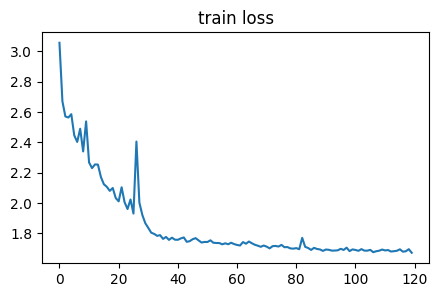

In [12]:
plt.figure(figsize=(5, 3))
plt.plot(loss_hist)
plt.title("train loss")
plt.show()

## 7. Check result

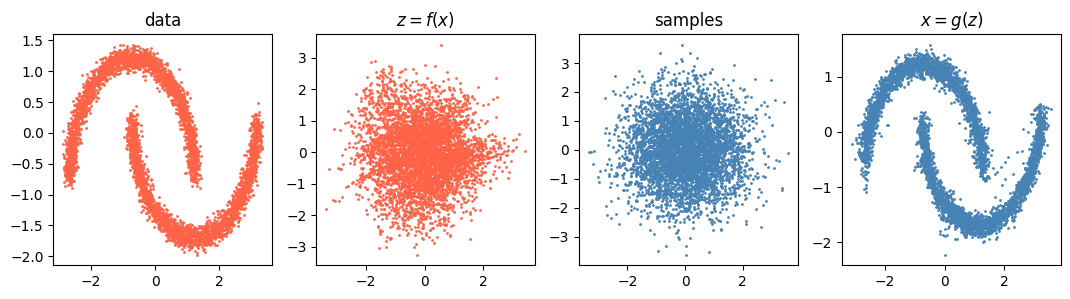

In [13]:
show_distribution(moon_data, state, num_samples=5000)